# 日経平均株価 日足

In [10]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '^N225'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-06-20 00:00:00+09:00,38410.320312,38637.621094,38263.078125,38633.019531,88000000,0.0,0.0
2024-06-21 00:00:00+09:00,38608.660156,38795.679688,38532.128906,38596.468750,140800000,0.0,0.0
2024-06-24 00:00:00+09:00,38497.421875,38905.468750,38416.070312,38804.648438,93500000,0.0,0.0
2024-06-25 00:00:00+09:00,38833.898438,39215.070312,38758.070312,39173.148438,108300000,0.0,0.0
2024-06-26 00:00:00+09:00,39364.730469,39788.628906,39233.558594,39667.070312,108900000,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-16 00:00:00+09:00,39551.218750,39632.171875,39371.421875,39457.488281,87500000,0.0,0.0
2024-12-17 00:00:00+09:00,39589.648438,39796.218750,39364.679688,39364.679688,115700000,0.0,0.0
2024-12-18 00:00:00+09:00,39176.878906,39382.691406,39081.710938,39081.710938,132200000,0.0,0.0


## パラボリック SAR

In [11]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/%5EN225?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=%5EN225&crumb=zzsEMrolCiZ


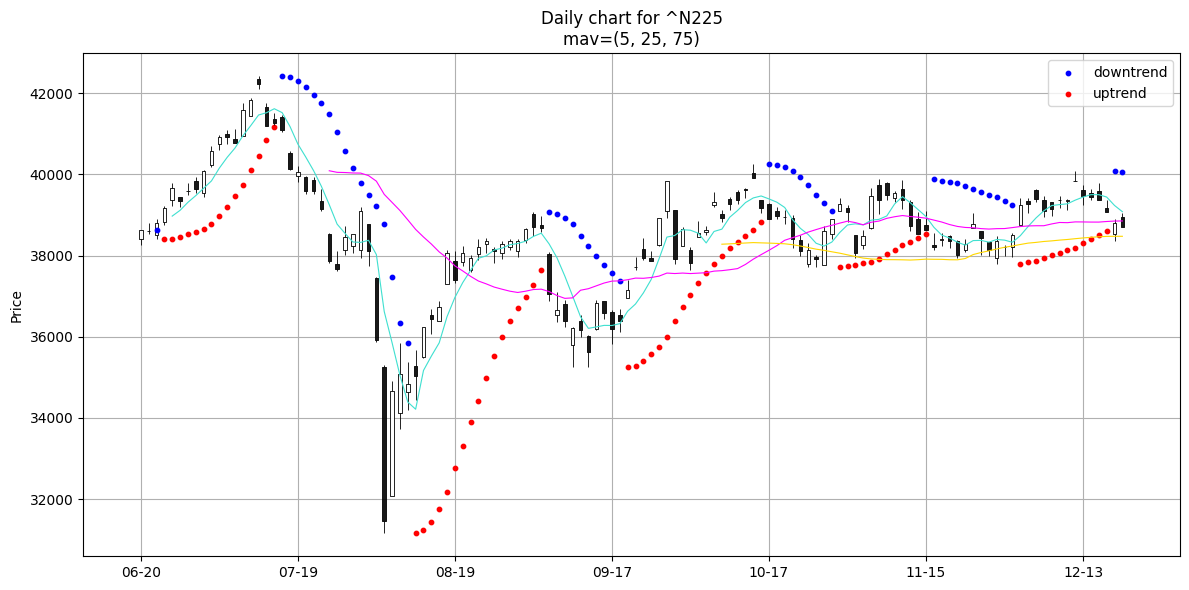

In [12]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_n225.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-12-19 00:00:00+09:00    38813.578125
2024-12-20 00:00:00+09:00    38701.898438
Name: Close, dtype: float64

In [25]:
df.tail(2)['Close'].diff()

Date
2024-12-19 00:00:00+09:00           NaN
2024-12-20 00:00:00+09:00    188.390625
Name: Close, dtype: float64

In [26]:
df['Close'].rolling(25).mean()

Date
2024-06-20 00:00:00+09:00             NaN
2024-06-21 00:00:00+09:00             NaN
2024-06-24 00:00:00+09:00             NaN
2024-06-25 00:00:00+09:00             NaN
2024-06-26 00:00:00+09:00             NaN
                                 ...     
2024-12-16 00:00:00+09:00    38827.625000
2024-12-17 00:00:00+09:00    38827.168594
2024-12-18 00:00:00+09:00    38841.570625
2024-12-19 00:00:00+09:00    38852.685781
2024-12-20 00:00:00+09:00    38867.048125
Name: Close, Length: 126, dtype: float64

In [27]:
df['Close'].rolling(75).mean()

Date
2024-06-20 00:00:00+09:00             NaN
2024-06-21 00:00:00+09:00             NaN
2024-06-24 00:00:00+09:00             NaN
2024-06-25 00:00:00+09:00             NaN
2024-06-26 00:00:00+09:00             NaN
                                 ...     
2024-12-16 00:00:00+09:00    38452.025417
2024-12-17 00:00:00+09:00    38465.264323
2024-12-18 00:00:00+09:00    38474.853385
2024-12-19 00:00:00+09:00    38477.064427
2024-12-20 00:00:00+09:00    38481.079063
Name: Close, Length: 126, dtype: float64